### Notas de aula de Computação Quântica <br> Autor: Jonas Maziero

# Mitigação de erros (com pós-processamento)
Usando as instruções em (https://qiskit.org/documentation/tutorials/noise/3_measurement_error_mitigation.html), podemos calibrar medidas em uma base completa, medir desvios dos resultados esperados e então corrigir resultados posteriores baseados nesses desvios.

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute, IBMQ
from qiskit.providers.aer import noise
from qiskit.providers.aer.noise import NoiseModel
from qiskit.visualization import plot_histogram
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter

In [2]:
qr = QuantumRegister(5)
qubit_list = [2, 3, 4] # os qubits para os quais aplicaremos calibracao de medidas
meas_calibs, state_labels = complete_meas_cal(qubit_list = qubit_list, qr = qr)

In [21]:
print(state_labels)

['000', '001', '010', '011', '100', '101', '110', '111']


In [23]:
meas_calibs # circuitos que serao executados para obter dados para calibracao (uma para cada state_labels)

## Cálculo da matriz de calibração

In [28]:
nshots = 8192
simulator = Aer.get_backend('qasm_simulator')
job = execute(meas_calibs, backend = simulator, shots = nshots) # executa a calibracao
cal_results = job.result()

In [29]:
# a matriz de calibracao sem ruido e a identidade
meas_fitter = CompleteMeasFitter(cal_results, state_labels)
print(meas_fitter.cal_matrix)

[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]


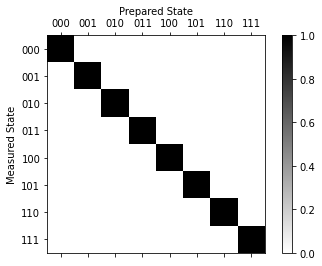

In [30]:
meas_fitter.plot_calibration()

In [31]:
provider = IBMQ.load_account()
device = provider.get_backend('ibmq_bogota')
noise_model = NoiseModel.from_backend(device)
basis_gates = noise_model.basis_gates
coupling_map = device.configuration().coupling_map

ibmqfactory.load_account:WARNING:2022-02-08 14:40:21,057: Credentials are already in use. The existing account in the session will be replaced.


In [32]:
job = execute(meas_calibs, backend = simulator, shots = nshots, noise_model = noise_model, 
             basis_gates = basis_gates, coupling_map = coupling_map)
cal_results = job.result()

In [33]:
meas_fitter = CompleteMeasFitter(cal_results, state_labels)
print(meas_fitter.cal_matrix)

[[9.48486328e-01 4.33349609e-02 1.65039062e-01 7.20214844e-03
  3.21044922e-02 2.19726562e-03 5.37109375e-03 0.00000000e+00]
 [1.59912109e-02 9.17602539e-01 1.83105469e-03 1.63940430e-01
  7.32421875e-04 3.35693359e-02 0.00000000e+00 5.73730469e-03]
 [2.56347656e-02 9.76562500e-04 8.12133789e-01 3.88183594e-02
  4.88281250e-04 0.00000000e+00 2.77099609e-02 1.58691406e-03]
 [2.44140625e-04 2.77099609e-02 1.11083984e-02 7.81982422e-01
  0.00000000e+00 4.88281250e-04 3.66210938e-04 2.83203125e-02]
 [9.03320312e-03 3.66210938e-04 2.19726562e-03 0.00000000e+00
  9.23950195e-01 3.95507812e-02 1.60522461e-01 9.39941406e-03]
 [4.88281250e-04 9.03320312e-03 1.22070312e-04 1.22070312e-03
  1.51367188e-02 8.98559570e-01 1.83105469e-03 1.51367188e-01]
 [1.22070312e-04 1.22070312e-04 7.56835938e-03 2.44140625e-04
  2.72216797e-02 9.76562500e-04 7.90283203e-01 3.52783203e-02]
 [0.00000000e+00 8.54492188e-04 0.00000000e+00 6.59179688e-03
  3.66210938e-04 2.46582031e-02 1.39160156e-02 7.68310547e-01]]

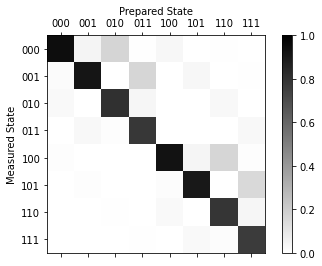

In [35]:
# visualizacao grafica da matriz de calibracao
meas_fitter.plot_calibration()

## Aplicando a calibração

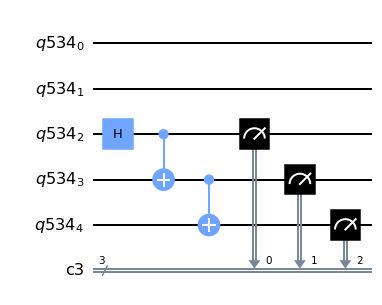

In [36]:
qr = QuantumRegister(5); cr = ClassicalRegister(3); qc_ghz = QuantumCircuit(qr, cr)
qc_ghz.h(qr[2]); qc_ghz.cx(qr[2], qr[3]); qc_ghz.cx(qr[3], qr[4])
qc_ghz.measure(qr[2], cr[0]); qc_ghz.measure(qr[3], cr[1]); qc_ghz.measure(qr[4], cr[2]);
qc_ghz.draw(output = 'mpl')

In [14]:
qubit_list = [2, 3, 4] # os qubits para os quais aplicaremos calibracao de medidas
meas_calibs, state_labels = complete_meas_cal(qubit_list = qubit_list, qr = qr)

In [37]:
job = execute(meas_calibs, backend = simulator, shots = nshots, noise_model = noise_model, 
             basis_gates = basis_gates, coupling_map = coupling_map)
cal_results = job.result()

In [38]:
meas_fitter = CompleteMeasFitter(cal_results, state_labels)

In [39]:
job = execute(qc_ghz, backend = simulator, shots = nshots, noise_model = noise_model, 
             basis_gates = basis_gates, coupling_map = coupling_map)
unmitigated_counts = job.result().get_counts() # resultados sem mitigacao de erros

In [40]:
# Resultados com mitigacao de erros
mitigated_results = meas_fitter.filter.apply(job.result())
mitigated_counts = mitigated_results.get_counts()

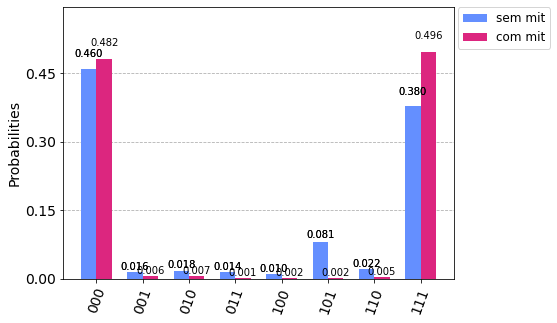

In [41]:
plot_histogram([unmitigated_counts, mitigated_counts], legend=['sem mit', 'com mit'])

## Tomografia de estado com mitigação de erros, com ruído simulado

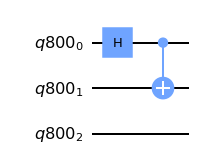

In [46]:
qr = QuantumRegister(3); qc = QuantumCircuit(qr); qc.h([0]); qc.cx([0], [1])
qc.draw(output = 'mpl')

In [47]:
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter

In [48]:
qstc = state_tomography_circuits(qc, [qr[0], qr[1]])
job = execute(qstc, backend = simulator, shots = nshots)
qstf = StateTomographyFitter(job.result(), qstc)
rho = qstf.fit(method = 'lstsq')
print(rho.real)

[[ 5.01598551e-01 -9.41776583e-04 -8.06610926e-04  4.98392867e-01]
 [-9.41776583e-04  5.00268433e-04  4.67440884e-04 -1.96306373e-03]
 [-8.06610926e-04  4.67440884e-04  5.03917493e-04 -1.82459225e-03]
 [ 4.98392867e-01 -1.96306373e-03 -1.82459225e-03  4.97397263e-01]]


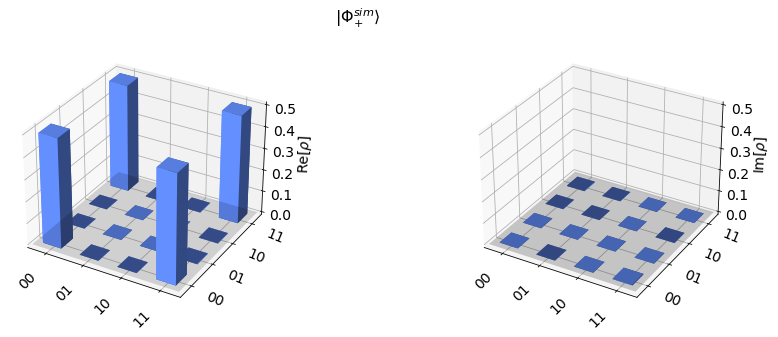

In [49]:
from qiskit.visualization import plot_state_city
plot_state_city(rho, title=r'$|\Phi_{+}^{sim}\rangle$')

In [58]:
device = provider.get_backend('ibmq_bogota')
noise_model = NoiseModel.from_backend(device)
basis_gates = noise_model.basis_gates
coupling_map = device.configuration().coupling_map
job = execute(qstc, backend = simulator, shots = nshots, noise_model = noise_model, 
             basis_gates = basis_gates, coupling_map = coupling_map)
qstf = StateTomographyFitter(job.result(), qstc)
rho = qstf.fit(method='lstsq')
print(rho.real)

[[0.48477844 0.00645344 0.00854517 0.42195931]
 [0.00645344 0.03808008 0.00162391 0.01007847]
 [0.00854517 0.00162391 0.03757403 0.00992783]
 [0.42195931 0.01007847 0.00992783 0.43956745]]


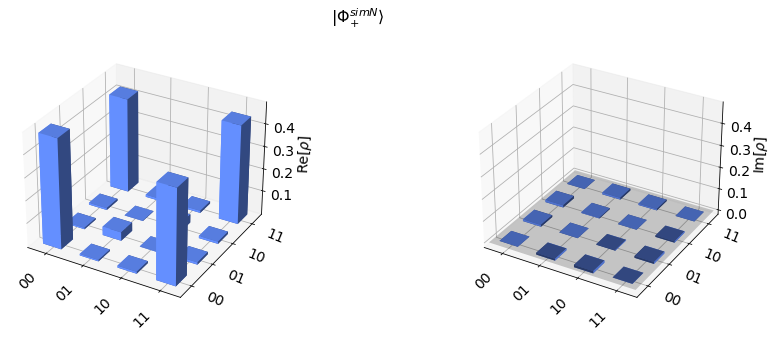

In [59]:
plot_state_city(rho, title=r'$|\Phi_{+}^{simN}\rangle$')

In [52]:
qubit_list = [0, 1] 
meas_calibs, state_labels = complete_meas_cal(qubit_list = qubit_list, qr = qr)
job = execute(meas_calibs, backend = simulator, shots = nshots, noise_model = noise_model, 
             basis_gates = basis_gates, coupling_map = coupling_map)
cal_results = job.result()
meas_fitter = CompleteMeasFitter(cal_results, state_labels)

In [53]:
qstc = state_tomography_circuits(qc, [qr[0], qr[1]])
job = execute(qstc, backend = simulator, shots = nshots, noise_model = noise_model, 
             basis_gates = basis_gates, coupling_map = coupling_map)
mitigated_results = meas_fitter.filter.apply(job.result())
qstf = StateTomographyFitter(mitigated_results, qstc)
rho = qstf.fit(method = 'lstsq')
print(rho.real)

[[ 0.50029514  0.00234701  0.00088874  0.48751115]
 [ 0.00234701  0.00280265  0.0026361  -0.00503093]
 [ 0.00088874  0.0026361   0.00261523 -0.00598496]
 [ 0.48751115 -0.00503093 -0.00598496  0.49428698]]


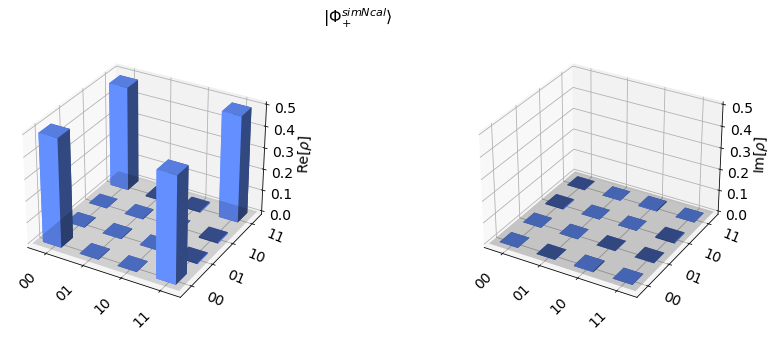

In [54]:
plot_state_city(rho, title=r'$|\Phi_{+}^{simNcal}\rangle$')

## Tomografia de estado com mitigação de erros, no chip real

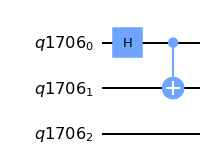

In [60]:
qr = QuantumRegister(3); qc = QuantumCircuit(qr); qc.h([0]); qc.cx([0], [1])
qc.draw(output = 'mpl')

In [43]:
provider = IBMQ.get_provider(hub = 'ibm-q-research-2', group = 'federal-uni-sant-1', project = 'main')
device = provider.get_backend('ibmq_bogota')
from qiskit.tools.monitor import job_monitor

In [44]:
qstc = state_tomography_circuits(qc, [qr[0], qr[1]])
job_exp = execute(qstc, backend = device, shots = nshots); job_monitor(job_exp)
qstf = StateTomographyFitter(job_exp.result(), qstc)
rho = qstf.fit(method = 'lstsq'); print(rho.real)

Job Status: job has successfully run
[[0.47231205 0.02000599 0.02563442 0.39505897]
 [0.02000599 0.04905997 0.00305607 0.01235205]
 [0.02563442 0.00305607 0.05004285 0.02266414]
 [0.39505897 0.01235205 0.02266414 0.42858512]]


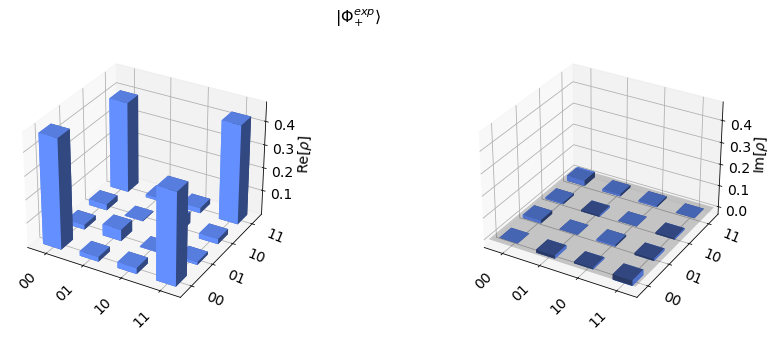

In [45]:
plot_state_city(rho, title=r'$|\Phi_{+}^{exp}\rangle$')

In [39]:
qubit_list = [0, 1] # os qubits para os quais aplicaremos calibracao de medidas
meas_calibs, state_labels = complete_meas_cal(qubit_list = qubit_list, qr = qr)
job = execute(meas_calibs, backend = device, shots = nshots)
job_monitor(job)
cal_results = job.result()
meas_fitter = CompleteMeasFitter(cal_results, state_labels)

Job Status: job has successfully run


In [46]:
mitigated_results = meas_fitter.filter.apply(job_exp.result())
qstf = StateTomographyFitter(mitigated_results, qstc)
rho = qstf.fit(method = 'lstsq'); print(rho.real)

[[4.93587976e-01 1.12084948e-02 1.62978032e-02 4.73031572e-01]
 [1.12084948e-02 9.24302965e-03 1.64332976e-04 3.85132678e-03]
 [1.62978032e-02 1.64332976e-04 1.26266742e-02 1.81489455e-02]
 [4.73031572e-01 3.85132678e-03 1.81489455e-02 4.84542321e-01]]


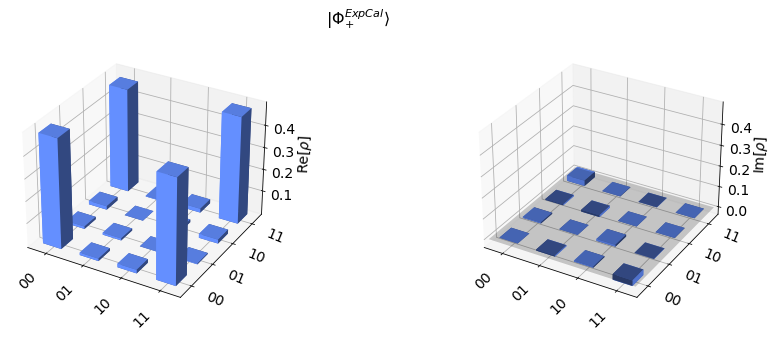

In [47]:
plot_state_city(rho, title=r'$|\Phi_{+}^{ExpCal}\rangle$')

Tenho a impressão que, em geral, a mitigação diminui o erro dos elemento de $\rho$ de uma ordem de grandeza.